### Imports

In [13]:
import os
from collections import Counter

import numpy as np
import pandas as pd
from functions.draw_cards import draw_cards, translate_vecs_to_cards
from main import generate_shuffled_deck, get_sets_on_table
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter


print(os.getcwd())


/Users/peterlucas/repos/set-simulation


### Load data

In [5]:
simul_data = pd.read_pickle("artifacts/set_simul_20220221_341726.pkl")
print(f"number of rows in simulation data: {len(simul_data)}")
NUM_GAMES_PLAYED = simul_data.game_id.max()
print(f"number of games played in simulation: {NUM_GAMES_PLAYED}")

number of rows in simulation data: 27333
number of games played in simulation: 1000


### Frequency of number of SETs on the table in any given round
*When there are at least 12 cards on the table*

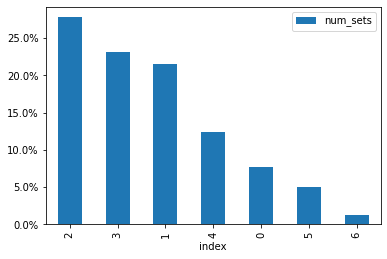

In [6]:
(
    simul_data.query("num_cards_table >= 12")["num_sets"]
    .value_counts(normalize=True)
    .reset_index()
    .query("num_sets >= 0.01")
    .plot(kind="bar", x="index", y="num_sets")
)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

### Dimension sameness in SETs
There are 4 dimensions on each card (number, color, shape, pattern). Counting the average number of dimensions that are the same across sets in a game.

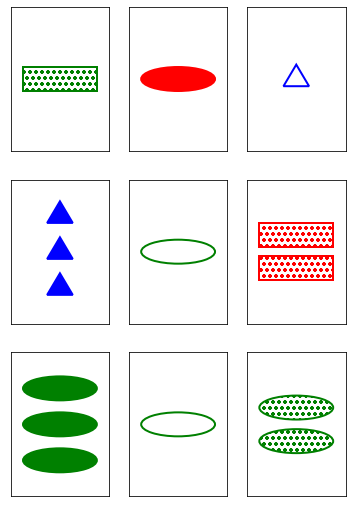

In [7]:
all_sets = simul_data[["sets"]].iloc[0, 0][0]
selected_sets = all_sets[:3, :, :].reshape(-1, 4)
draw_cards(translate_vecs_to_cards(selected_sets))

In [8]:
def count_same_dimensions(set_):
    """
    If the set of numbers in a SET (set_) dimension contains only a single type, then it's
    length is 1.
    This function loops through each dimensions of a SET --> for i in range(set_.shape[-1])
    And checks if the length of the given dimension is 1 --> len(set(set_[..., i])) == 1
    Then returns the sum, that is the number of dimensions where sameness is found
    """
    return sum([len(set(set_[..., i])) == 1 for i in range(set_.shape[-1])])


In [9]:
def avg_num_same_dimensions_in_sets(sets):
    set_dim_samenesses = [count_same_dimensions(set_) for set_ in sets]
    return np.mean(set_dim_samenesses)

In [10]:
sets_in_rounds = simul_data[simul_data["num_sets"] > 0]["sets"]

# The above is still a pd.DF, need to turn it into a list of ndarrays
list_of_sets = [set[0] for set in sets_in_rounds]
dim_sameness = avg_num_same_dimensions_in_sets(np.concatenate(list_of_sets, axis=0))
print(
    f"{round(dim_sameness, 2)} is the average number of dimensions that are identical "
    f"in a SET (out of the 4 dimensions)"
)


1.3 is the average number of dimensions that are identical in a SET (out of the 4 dimensions)


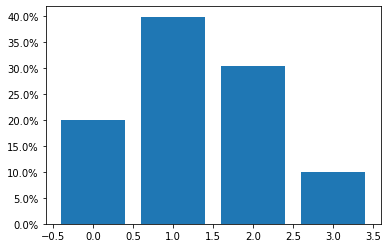

In [240]:
set_samenesses = [
    count_same_dimensions(set_) for set_ in np.concatenate(list_of_sets, axis=0)
]
set_sameness_frequency = dict(Counter(set_samenesses))
plt.bar(
    set_sameness_frequency.keys(),
    [frequency / len(set_samenesses) for frequency in set_sameness_frequency.values()],
)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

### Number of sets found during a game

In [241]:
num_remaining_cards_on_table = simul_data.query("is_last_round == True")[
    "num_cards_table"
]

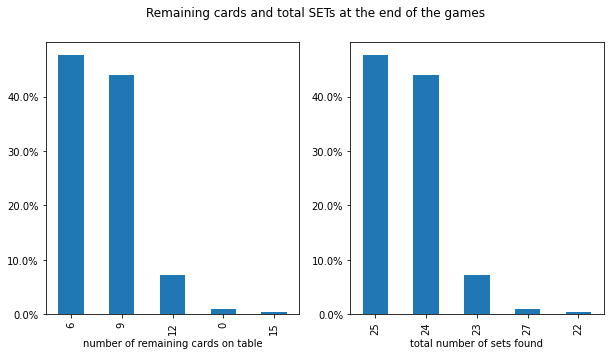

In [242]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
total_num_sets = ((81 - num_remaining_cards_on_table) / 3).astype(int)
data_to_plot = [num_remaining_cards_on_table, total_num_sets]
x_axis_titles = ["number of remaining cards on table", "total number of sets found"]
for i, df in enumerate(data_to_plot):
    (
        df
        .value_counts(normalize=True)
        .reset_index()
        .plot(
            kind="bar",
            x="index",
            y="num_cards_table",
            ax=ax[i],
            legend=False,
            xlabel=x_axis_titles[i],
            sort_columns=True,
        )
    )
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

fig.suptitle("Remaining cards and total SETs at the end of the games")
plt.show()

### Average number of rounds per game where no SET is found

In [250]:
foo = simul_data.head()

In [26]:
rounds_wo_set = (
    len(simul_data.query("num_sets == 0 & is_last_round == False").index) /
    NUM_GAMES_PLAYED
)

print(f"On average there are {rounds_wo_set} rounds w/o any SET found.")

On average there are 1.905 rounds w/o any SET found.


### Total number of sets in a deck

In [16]:
deck = generate_shuffled_deck()
sets_in_deck = get_sets_on_table(deck)
print(f"Number of possible SETs in a deck: {len(sets_in_deck)}.")

Number of possible SETs in a deck: 1080.
